# import libaries & Load QMUL dataset

In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np

from torch.autograd import Variable
from PIL import Image

from model.model import PixEncoder, SeqDecoder
from config import Config

import numpy as np
from utils.draw import draw_strokes
import h5py

import cv2
import matplotlib.pyplot as plt

# Load trained models

In [2]:
from model.model import PixDecoder, SeqEncoder

config = Config("./configs/default_config.yml")
weight_epoch = 3000

pix_enc = PixEncoder(config)
pix_dec = PixDecoder(config)
seq_enc = SeqEncoder(config)
seq_dec = SeqDecoder(config)

pix_enc.load_state_dict(torch.load(f"./weights/QMUL/pix_enc_{weight_epoch}.pt"))
pix_dec.load_state_dict(torch.load(f"./weights/QMUL/pix_dec_{weight_epoch}.pt"))
seq_enc.load_state_dict(torch.load(f"./weights/QMUL/seq_enc_{weight_epoch}.pt"))
seq_dec.load_state_dict(torch.load(f"./weights/QMUL/seq_dec_{weight_epoch}.pt"))
# seq_enc.load_state_dict(torch.load(f"./weights/QuickDraw/seq_enc_20000.pt"))
# seq_dec.load_state_dict(torch.load(f"./weights/QuickDraw/seq_dec_20000.pt"))
seq_dec.training = False

pix_enc.cuda()
pix_dec.cuda()
seq_dec.cuda()
seq_enc.cuda()

pix_enc.eval()
pix_dec.eval()
seq_dec.eval()
seq_enc.eval()

device = config.device

/home/joono/anaconda3/envs/pytorch1_10/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Load DataLoader

In [3]:
from data.dataloader import QMULLoader, QuickDrawLoader

qmulloader = QMULLoader(config)
quickdrawloader = QuickDrawLoader(config)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

batch_size = 1

/home/joono/MinLab/sketch-photo2seq-torch/data/dataloader.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), d["image_base_name"]


# QuickDraw Sketch data

sketch: torch.Size([69, 1, 5]), length: [47]


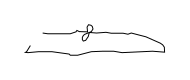

In [4]:
# sketch, length, image = qmulloader.get_batch(batch_size=batch_size)
sketch, length = quickdrawloader.get_batch(batch_size=batch_size)
# print(f"sketch: {sketch.shape}, length: {length}, image: {image.shape}")
print(f"sketch: {sketch.shape}, length: {length}")
# print(sketch)

for i in range(batch_size):
    sketch_drawable = sketch[:length[i], i, :-2]
    sketch_drawable[:, -1] = 1 - sketch_drawable[:, -1]
    # print(sketch_drawable)
    draw_strokes(sketch_drawable, factor=0.1)

# QuickDraw s2s

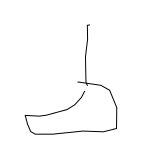

/home/joono/MinLab/sketch-photo2seq-torch/model/model.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0,1).squeeze()).view(len_out,-1,self.M)
/home/joono/MinLab/sketch-photo2seq-torch/model/model.py:160: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(params_pen).view(len_out,-1,3)


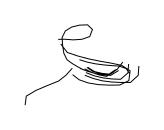

In [5]:
sketch, length = quickdrawloader.get_batch(batch_size=batch_size)
Nmax = 131

for i in range(batch_size):
    z, _, _ = seq_enc(sketch, batch_size)

    sketch_drawable = sketch[:length[i], i, :-2]
    sketch_drawable[:, -1] = 1 - sketch_drawable[:, -1]
    # print(sketch_drawable)
    draw_strokes(sketch_drawable, factor=0.1)

    s = Variable(torch.stack([torch.Tensor([0, 0, 1, 0, 0])]).to(device)).unsqueeze(0)
    batch_init = torch.cat([s])
    z_stack = torch.stack([z])
    inputs = torch.cat([batch_init, z_stack], 2)

    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell = seq_dec(inputs, z, batch_size)
    pen_state = torch.argmax(q)

    sketches = []
    while pen_state != 2:
        pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell = seq_dec(inputs, z, batch_size, (hidden, cell))
        pen_state = torch.argmax(q)
        q = torch.eye(3)[pen_state]
        mu_s_idx = torch.argmax(pi)
        x, y = mu_x[0, 0, mu_s_idx], mu_y[0, 0, mu_s_idx],
        
        s[0, 0, 0] = x
        s[0, 0, 1] = y
        s[0, 0, 2:] = q
        inputs = torch.cat([s, z_stack], 2)
        
        sketches.append([x.item(), y.item(), pen_state.item()])

    sketches = np.array(sketches)
    draw_strokes(sketches, 0.1)

# QMUL p2s

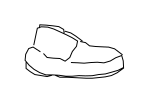

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


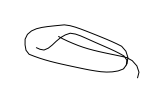

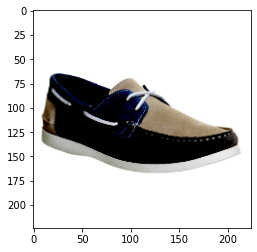

In [26]:
sketch, length, images = qmulloader.get_batch(batch_size)

Nmax = 131
for i in range(batch_size):
    sketch_drawable = sketch[:length[i], i, :-2]
    sketch_drawable[:, -1] = 1 - sketch_drawable[:, -1]
    draw_strokes(sketch_drawable, factor=0.1)
    
    plt.figure(i)
    plt.imshow(images[i].cpu().numpy().transpose((1,2,0)))
    
    z, _, _ = pix_enc(images[i].unsqueeze(0))
    
    s = Variable(torch.stack([torch.Tensor([0, 0, 1, 0, 0])]).to(device)).unsqueeze(0)
    batch_init = torch.cat([s])
    z_stack = torch.stack([z])
    inputs = torch.cat([batch_init, z_stack], 2)

    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell = seq_dec(inputs, z, batch_size)
    pen_state = torch.argmax(q)

    sketches = []
    while pen_state != 2:
        pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell = seq_dec(inputs, z, batch_size, (hidden, cell))
        pen_state = torch.argmax(q)
        q = torch.eye(3)[pen_state]
        mu_s_idx = torch.argmax(pi)
        x, y = mu_x[0, 0, mu_s_idx], mu_y[0, 0, mu_s_idx],
        
        s[0, 0, 0] = x
        s[0, 0, 1] = y
        s[0, 0, 2:] = q
        inputs = torch.cat([s, z_stack], 2)
        
        sketches.append([x.item(), y.item(), pen_state.item()])

    sketches = np.array(sketches)
    draw_strokes(sketches, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


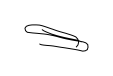

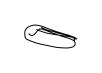

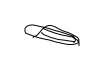

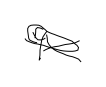

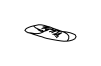

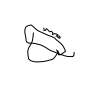

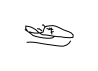

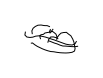

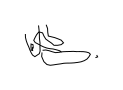

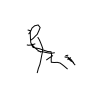

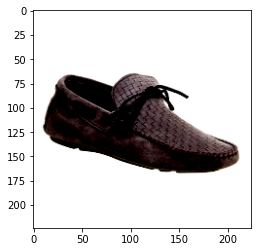

In [38]:
import utils.draw as draw

sketch, length, images = qmulloader.get_batch(batch_size)
plt.imshow(images.squeeze(0).detach().cpu().numpy().transpose((1, 2, 0)))
for i in range(1, 11):
    strokes = draw.sample(pix_enc, seq_dec, images, device, max_len=250, temperature=0.1 * i)
    draw_strokes(strokes)

# QMUL p2p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


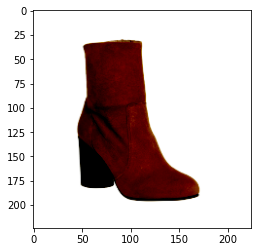

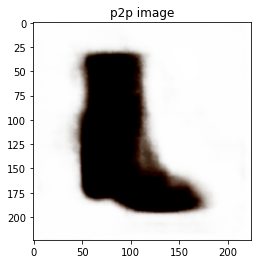

In [8]:
sketch, length, images = qmulloader.get_batch(batch_size)

for i in range(batch_size):
    plt.figure(i)
    plt.imshow(images[i].cpu().numpy().transpose((1,2,0)))
    
    z, _, _ = pix_enc(images[i].unsqueeze(0))
    
    p2p_img = pix_dec(z)
        
    plt.figure(2)
    plt.title("p2p image")
    plt.imshow(p2p_img.squeeze(0).detach().cpu().detach().numpy().transpose((1,2,0)))

# QuickDraw loader validation - OK

In [9]:
data = np.load(config.data["quick_draw"], encoding = 'latin1', allow_pickle=True)
data = data["train"]

In [10]:
def calculate_normalizing_scale_factor(strokes):
    """Calculate the normalizing factor explained in appendix of sketch-rnn."""
    data = []
    for i in range(len(strokes)):
        for j in range(len(strokes[i])):
            data.append(strokes[i][j, 0])
            data.append(strokes[i][j, 1])
    data = np.array(data)
    return np.std(data)

def normalize(strokes):
    """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
    data = []
    scale_factor = calculate_normalizing_scale_factor(strokes)
    for seq in strokes:
        seq[:, 0:2] /= scale_factor
        data.append(seq)
    return data
def purify(strokes):
    data = []
    for seq in strokes:
        if len(seq[:, 0]) <= config.hypers["max_seq_length"] and len(seq[:, 0]) > 10:
            seq = np.minimum(seq, 1000)
        seq = np.maximum(seq, -1000)
        seq = np.array(seq, dtype = np.float32)
        data.append(seq)
    return data

data_purify = purify(data)
data_normal = normalize(data_purify)

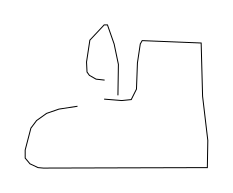

In [11]:
draw_strokes(data_normal[1000], factor=0.05)

In [12]:
a = torch.tensor([[1., 2., 3.]])
print(a, a.shape)

tensor([[1., 2., 3.]]) torch.Size([1, 3])


In [13]:
b = torch.nn.functional.softmax(a, dim=1)

In [14]:
b

tensor([[0.0900, 0.2447, 0.6652]])